<a href="https://colab.research.google.com/github/dmamur/struct2prop/blob/main/embed_phdos_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pickle,re, glob,os,random 
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Embedding,Dense,Dropout,Input,Concatenate,Flatten,Bidirectional,LSTM,Reshape
from keras.utils import np_utils
from keras.utils.vis_utils import plot_model
import keras.backend as K 
from collections import defaultdict

loss_fn = keras.losses.SparseCategoricalCrossentropy(
    reduction=tf.keras.losses.Reduction.NONE
)
loss_tracker = tf.keras.metrics.Mean(name="loss")

class MaskedLanguageModel(tf.keras.Model):
    def train_step(self, inputs):
        if len(inputs) == 3:
            features, labels, sample_weight = inputs
        else:
            features, labels = inputs
            sample_weight = None

        with tf.GradientTape() as tape:
            predictions = self(features, training=True)
            loss = loss_fn(labels, predictions, sample_weight=sample_weight)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Compute our own metrics
        loss_tracker.update_state(loss, sample_weight=sample_weight)

        # Return a dict mapping metric names to current value
        return {"loss": loss_tracker.result()}

    @property
    def metrics(self):
        # We list our `Metric` objects here so that `reset_states()` can be
        # called automatically at the start of each epoch
        # or at the start of `evaluate()`.
        # If you don't implement this property, you have to call
        # `reset_states()` yourself at the time of your choosing.
        return [loss_tracker]

def loadData(fname,printkeys='y'):
    # for reading also binary mode is important
    dbfile = open(fname, 'rb')     
    db = pickle.load(dbfile)
    if printkeys=='y':
        for keys in db:
            print(keys)
    return db



In [ ]:
!git clone https://github.com/dmamur/struct2prop.git 
!git clone https://github.com/ninarina12/phononDoS_tutorial.git
%cd phononDoS_tutorial

Cloning into 'struct2prop'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 54 (delta 16), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (54/54), 3.03 MiB | 5.25 MiB/s, done.
Cloning into 'phononDoS_tutorial'...
remote: Enumerating objects: 299, done.
remote: Counting objects: 100% (5/5), done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 299 (delta 1), reused 3 (delta 0), pack-reused 294
Receiving objects: 100% (299/299), 83.16 MiB | 12.10 MiB/s, done.
Resolving deltas: 100% (154/154), done.
/content/phononDoS_tutorial


In [ ]:
class Config:
    MAX_LEN = 128
    BATCH_SIZE = 1
    LR = 0.001
    VOCAB_SIZE = 128
    EMBED_DIM = 128
    MNAME = 'embed_aunps_'
config = Config()
path="/content/struct2prop/models"
mname=path+config.MNAME+'E_'+str(config.EMBED_DIM)
tf.random.set_seed(42)

In [ ]:
!pip install ase

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 21.0 MB/s eta 0:00:00


# Load data from CIF

In [ ]:
from ase.io import read
from ase import Atoms
from scipy.ndimage import gaussian_filter1d
from ase.neighborlist import neighbor_list
def getpdf(atoms,x,v):
    i, d = neighbor_list('id', atoms, 10.0, self_interaction=False)
    pdfatoms=[]
    for k,l in enumerate(atoms):
        y = np.zeros(100)
        dist = np.round(d[i==k]*10)
        a,b=np.unique(dist, return_counts=True)
        np.put(y,a.astype(int)-1,b)
        pdfatoms.append(gaussian_filter1d(y/v,1))
    return np.asarray(pdfatoms)

In [ ]:
# load data
df = pd.read_csv('data/data.csv')
df.head()

,mp_id,structure,phfreq,phdos,pdos
0,mp-1000,"{'numbers': [56, 52], 'positions': [[0.0, 0.0,...","[0.0, 20.0, 40.0, 60.0, 80.0, 100.0, 120.0, 14...","[0.0, 0.1603814665137704, 0.366293016390463, 0...","{'Ba': [0.0, 0.17004785173719497, 0.4321591874..."
1,mp-1002124,"{'numbers': [72, 6], 'positions': [[0.0, 0.0, ...","[0.0, 20.0, 40.0, 60.0, 80.0, 100.0, 120.0, 14...","[0.02337731725373556, 0.030910686260937723, 0....","{'Hf': [0.026541048236378005, 0.03587084551615..."
2,mp-1002164,"{'numbers': [32, 6], 'positions': [[0.0, 0.0, ...","[0.0, 20.0, 40.0, 60.0, 80.0, 100.0, 120.0, 14...","[0.0, 0.0017221473876927959, 0.005981246148731...","{'Ge': [0.0, 0.00316167053214679, 0.0109190651..."
3,mp-10044,"{'numbers': [5, 33], 'positions': [[4.44089209...","[0.0, 20.0, 40.0, 60.0, 80.0, 100.0, 120.0, 14...","[0.0, 0.002277293012378372, 0.0078646582782471...","{'B': [0.0, 0.00029269193672558846, 0.00105324..."
4,mp-1008223,"{'numbers': [20, 34], 'positions': [[0.0, 0.0,...","[0.0, 20.0, 40.0, 60.0, 80.0, 100.0, 120.0, 14...","[0.0, 0.258870972416879, 0.5505201512544314, 0...","{'Ca': [0.0, 0.11150000312651394, 0.2215562000..."


In [ ]:
df['phdos'] = df['phdos'].apply(eval).apply(np.array)
df['phfreq'] = df['phfreq'].apply(eval).apply(np.array)

In [ ]:
r = np.arange(0,10,0.1)
v = np.concatenate([[1],4*np.pi/3*(r[1:]**3 - r[:-1]**3)])
types,formula,ids,pdf,phdos = [],[],[],[],[]
for index, row in df.iterrows():
  atoms=Atoms.fromdict(eval(row['structure']))
  formula.append(atoms.get_chemical_formula())
  types.append(atoms.get_chemical_symbols())
  pdf.append(getpdf(atoms,r,v))
ids=df['mp_id'].to_list()

In [ ]:
# Load data for masked language model
with open('/content/struct2prop/data/el2id.pkl', 'rb') as f:
    el2id = pickle.load(f)
element2id = el2id['el2id']
config.VOCAB_SIZE = len(element2id)
print(config.VOCAB_SIZE)

94


In [ ]:
typesNumerical=[]
for i in types:
    typesNumerical.append([element2id[j] for j in i])

x1 = tf.keras.preprocessing.sequence.pad_sequences(pdf,dtype='float32',padding= 'post',maxlen=config.MAX_LEN )
x1[np.isnan(x1)]=0
x3 = tf.keras.preprocessing.sequence.pad_sequences(typesNumerical,dtype='int32',padding= 'post',maxlen=config.MAX_LEN)

In [ ]:
y  = tf.keras.preprocessing.sequence.pad_sequences(df['phdos'].to_numpy(),dtype='float32',padding= 'post')
p = np.random.RandomState(seed=73).permutation(y.shape[0])
n = len(p)
trainidx = p[:int(n*0.8)]
validx = p[int(n*0.8):int(n*0.9)]
testidx = p[int(n*0.9):]

x1v, x3v,ytrainv   =  x1[validx],  x3[validx],  y[validx]
x1t,  x3t, ytrain =  x1[trainidx],x3[trainidx],y[trainidx]

# Predict PhDOS
I shall use x_train2 as y_train but after replacing 20% of atoms with 0

In [ ]:
inputA = Input(shape=x1t.shape[1:],name='x1')
inputC = Input((config.MAX_LEN), dtype=tf.int32,name='types')
outNeuronNum = y.shape[1]
inputD = Input(shape=outNeuronNum,)

x = Bidirectional(LSTM(8,name='x1_lstm',return_sequences=True),name='x1_blstm')(inputA)
x = Model(inputs=inputA, outputs=x)

z =  Embedding(config.VOCAB_SIZE, config.EMBED_DIM, mask_zero=True,name="element_embdgs")(inputC)
z = Model(inputs=inputC, outputs=z)

combined = Concatenate()([x.output,z.output])

l = LSTM(256)(combined)

e = Dense(outNeuronNum, activation="relu",use_bias=True,name='out_edos')(l)
model = Model(inputs=[x.input, z.input], outputs=[e])

from tensorflow.keras.models import load_model
pretrained_model = load_model('/content/struct2prop/models/embed_pdf_E_128.h5',custom_objects={"MaskedLanguageModel": MaskedLanguageModel})
for layer in pretrained_model.layers:
    try:
        # selecting layer by name
        model.get_layer(layer.name).set_weights(layer.get_weights())
        model.get_layer(layer.name).trainable=False
        print(layer.name)
    except:
        pass

mname = mname+'_phDOS'


x1
types
x1_blstm
element_embdgs
concatenate


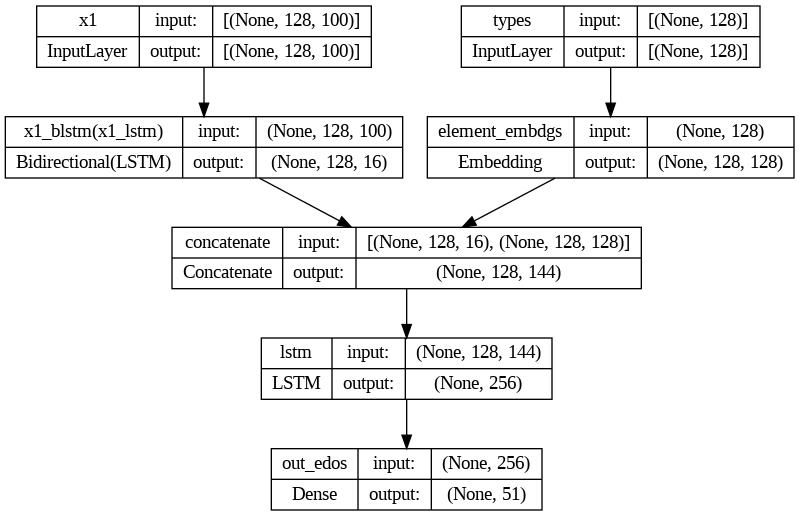

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True,to_file=mname+".png")

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 x1 (InputLayer)                [(None, 128, 100)]   0           []                               
                                                                                                  
 types (InputLayer)             [(None, 128)]        0           []                               
                                                                                                  
 x1_blstm (Bidirectional)       (None, 128, 16)      6976        ['x1[0][0]']                     
                                                                                                  
 element_embdgs (Embedding)     (None, 128, 128)     12032       ['types[0][0]']                  
                                                                                            

In [ ]:
model.compile(loss ='mae',
              optimizer= keras.optimizers.Adam(learning_rate=config.LR),
              metrics='mse')

In [ ]:
def scheduler(epoch):
    initial_lrate = config.LR
    drop = 0.92
    epochs_drop = 3
    lr = initial_lrate * np.power(drop, np.floor((1+epoch)/epochs_drop))
    if lr<0.0001:
        lr = 0.0001
    return lr

epochs=25*config.BATCH_SIZE
csv_logger = tf.keras.callbacks.CSVLogger(mname+"_log.csv", append=True)
earlyStopping= tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50, min_delta=0.01)
checkpoint = tf.keras.callbacks.ModelCheckpoint(mname+".h5",verbose=2,monitor='val_loss', mode='min',save_freq=5000)
callbacks_list = [checkpoint,csv_logger,earlyStopping,tf.keras.callbacks.LearningRateScheduler(scheduler)]

hist = model.fit(x=[x1t,x3t],y = [ytrain],validation_data = ([x1v, x3v],[ytrainv]),
                 initial_epoch = 0, epochs = epochs,batch_size = 32,callbacks = callbacks_list, verbose=1)


Epoch 1/25
39/39 [==============================] - 19s 497ms/step - loss: 0.0472 - mse: 0.0103 - val_loss: 0.0755 - val_mse: 0.0221 - lr: 0.0010
Epoch 2/25
39/39 [==============================] - 21s 542ms/step - loss: 0.0463 - mse: 0.0099 - val_loss: 0.0748 - val_mse: 0.0218 - lr: 0.0010
Epoch 3/25
39/39 [==============================] - 20s 513ms/step - loss: 0.0441 - mse: 0.0093 - val_loss: 0.0749 - val_mse: 0.0219 - lr: 9.2000e-04
Epoch 4/25
39/39 [==============================] - 21s 539ms/step - loss: 0.0413 - mse: 0.0087 - val_loss: 0.0745 - val_mse: 0.0219 - lr: 9.2000e-04
Epoch 5/25
39/39 [==============================] - 20s 509ms/step - loss: 0.0436 - mse: 0.0091 - val_loss: 0.0735 - val_mse: 0.0214 - lr: 9.2000e-04
Epoch 6/25
39/39 [==============================] - 21s 539ms/step - loss: 0.0420 - mse: 0.0087 - val_loss: 0.0743 - val_mse: 0.0215 - lr: 8.4640e-04
Epoch 7/25
39/39 [==============================] - 19s 496ms/step - loss: 0.0401 - mse: 0.0083 - val_loss: 

In [ ]:
preds = model.predict([x1,x3],batch_size = 32)

dbresults={}
dbresults['x4'] = df['phfreq'].to_numpy()
dbresults['y'] = y
dbresults['preds'] = preds
dbresults['train_idx'] = trainidx
dbresults['validate_idx'] = validx 
dbresults['test_idx'] = testidx
dbresults['formula'] = formula
dbresults['ids'] = ids

with open(mname+'_results.pkl', 'wb') as f:
    pickle.dump(dbresults, f)


48/48 [==============================] - 9s 190ms/step


MSE_test:  0.024808267 MAE_test:  0.08161792
mean_squared_error:  0.013236399
mean_absolute_error:  0.06786049


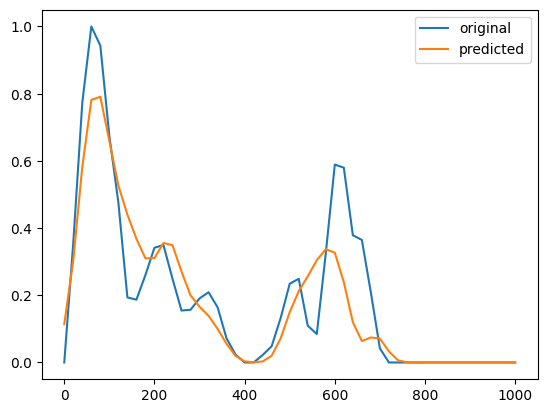

In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,median_absolute_error
ytest    = dbresults['y'][testidx]
x4t      = dbresults['x4'][testidx]
predtest = dbresults['preds'][testidx]
mset = np.asarray([mean_squared_error(i,j) for i,j in zip(ytest,predtest)])
maet = np.asarray([mean_absolute_error(i,j) for i,j in zip(ytest,predtest)])
mseTt=np.mean(mset)
maeTt=np.mean(maet)
print('MSE_test: ',mseTt,'MAE_test: ',maeTt)
#formula = [dbresults['formula'][i] for i in testidx]
#ids = [dbresults['ids'][i] for i in testidx]
ind=np.random.randint(len(ytest))
p = np.random.permutation(np.where(mset>0.)[0])
ind=p[0]#np.random.randint(len(ytrain))
y_true = ytest[ind]
y_pred = predtest[ind]
plt.plot(x4t[ind],y_true,label='original')
plt.plot(x4t[ind],gaussian_filter1d(y_pred,1),label='predicted')
#plt.plot(x4t[ind],gaussian_filter1d(y_true,1))
print('mean_squared_error: ',mean_squared_error(y_true,y_pred))
print('mean_absolute_error: ',mean_absolute_error(y_true,y_pred))
#plt.title(formula[ind].translate(sub), fontsize=16)
plt.legend();